In [1]:
# 코드 13-1 라이브러리 호출
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 코드 13-2 MNIST 데이터셋을 내려받아 전처리
transform = transforms.Compose(
    [transforms.ToTensor()]
)  # transforms.ToTensor( )는 이미지를 파이토치의 텐서 형태로 변형시켜 줍니다.

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True
)  # MNIST를 내려받은 후 텐서 형태로 변형

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True
)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False
)  # ①

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [3]:
# 코드 13-3 네트워크(신경망) 생성
class Encoder(nn.Module):  # 인코더 네트워크 생성
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
        )  # 이미지 데이터셋 처리를 위해 합성곱 신경망 이용

        self.flatten = nn.Flatten(start_dim=1)  # 완전연결층
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128), nn.ReLU(True), nn.Linear(128, encoded_space_dim)
        )  # 출력 계층

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


class Decoder(nn.Module):  # 디코더 네트워크 생성
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
        )  # 인코더의 출력을 디코더의 입력으로 사용

        self.unflatten = nn.Unflatten(
            dim=1, unflattened_size=(32, 3, 3)
        )  # 인코더의 완전연결층에 대응
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )  # 인코더의 합성곱층에 대응

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [4]:
# 코드 13-4 손실 함수와 옵티마이저 지정
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {"params": encoder.parameters()},
    {"params": decoder.parameters()},
]  # 인코더와 디코더에서 사용할 파라미터를 다르게 지정
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [5]:
# 코드 13-5 모델 학습 함수 생성
import numpy as np


def train_epoch(
    encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3
):
    encoder.train()  # 인코더 훈련
    decoder.train()  # 디코더 훈련
    train_loss = []
    for (
        image_batch,
        _,
    ) in (
        dataloader
    ):  # 훈련 데이터셋을 이용하여 모델 학습(비지도 학습으로 레이블은 필요하지 않습니다)
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(
            device
        )  # 데이터셋이 CPU/GPU 장치를 사용하도록 지정
        encoded_data = encoder(image_noisy)  # 노이즈 데이터를 인코더의 입력으로 사용
        decoded_data = decoder(encoded_data)  # 인코더 출력을 디코더의 입력으로 사용
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [6]:
# 코드 13-6 모델 테스트 함수 생성
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    # Set evaluation mode for encoder and decoder
    encoder.eval()  # 인코더 테스트
    decoder.eval()  # 디코더 테스트
    with torch.no_grad():
        conc_out = []  # 각 배치에 대한 출력을 저장하기 위해 리스트 형식의 변수 정의
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(
            conc_out
        )  # 리스트 형식으로 저장된 모든 값을 하나의 텐서로 생성
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)  # 손실 함수를 이용하여 오차 계산
    return val_loss.data

In [7]:
# 코드 13-7 노이즈 데이터 생성
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor  # ①
    noisy = torch.clip(noisy, 0.0, 1.0)  # ②
    return noisy

In [8]:
# 코드 13-8 한글 깨짐 문제 해결
from matplotlib import font_manager

# font_fname = "C:/Windows/Fonts/malgun.ttf"
font_fname = "/mnt/c/Windows/Fonts/malgun.ttf"
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [9]:
# 코드 13-9 이미지 시각화
def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        ax = plt.subplot(
            3, n, i + 1
        )  # subplot에서 사용하는 파라미터는 (행, 열, 인덱스)입니다. 3×5 형태의 이미지가 출력됩니다.
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()  # 인코더 평가
        decoder.eval()  # 디코더 평가
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(
            img.cpu().squeeze().numpy(), cmap="gist_gray"
        )  # 테스트 데이터셋을 출력
        ax.get_xaxis().set_visible(
            False
        )  # set_visible(False)는 그래프의 눈금을 표시하지 않겠다는 의미
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("원래 이미지")
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(
            image_noisy.cpu().squeeze().numpy(), cmap="gist_gray"
        )  # 테스트 데이터셋에 노이즈가 적용된 결과를 출력
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("노이즈가 적용되어 손상된 이미지")

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(
            rec_img.cpu().squeeze().numpy(), cmap="gist_gray"
        )  # 노이즈가 추가된 이미지를 인코더와 디코더에 적용한 결과를 출력
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title("재구성된 이미지")
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3
    )  # subplots_adjust()를 이용하여 subplot들이 겹치지 않도록 최소한의 여백을 만들어 줍니다.
    plt.show()

EPOCH 1/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/


 EPOCH 1/30 	 train loss 0.073 	 val loss 0.056


/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/halozhan/딥러닝 파이토치 교과서/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


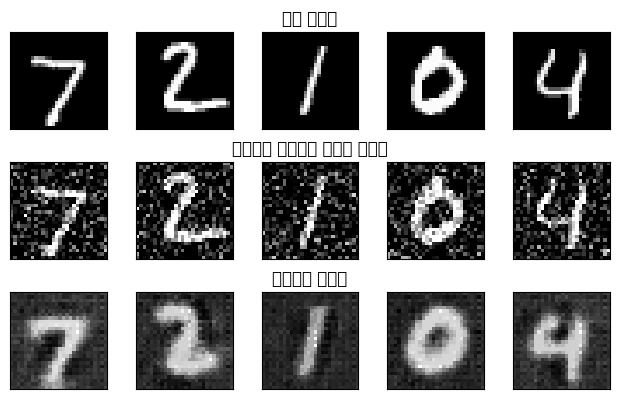

EPOCH 2/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 2/30 	 train loss 0.059 	 val loss 0.051


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


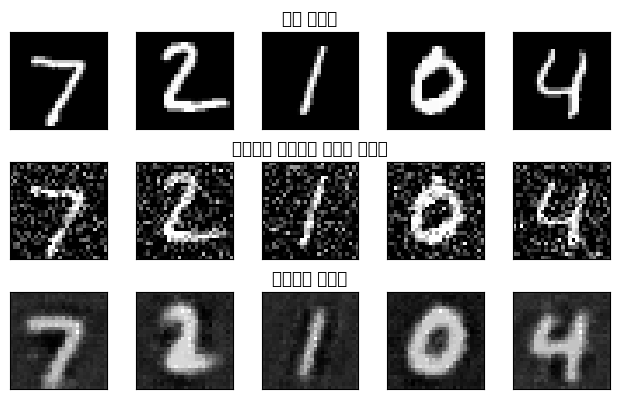

EPOCH 3/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 3/30 	 train loss 0.057 	 val loss 0.048


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


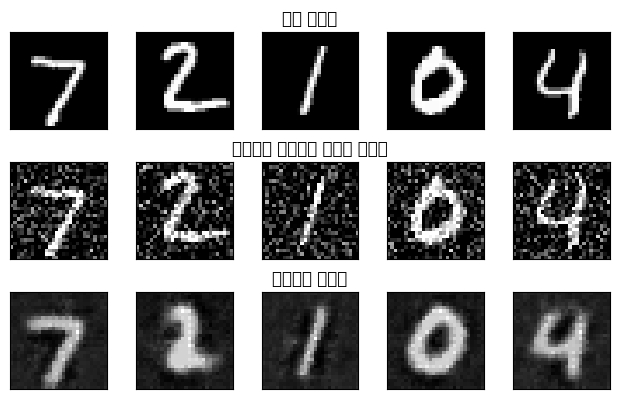

EPOCH 4/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 4/30 	 train loss 0.055 	 val loss 0.045


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


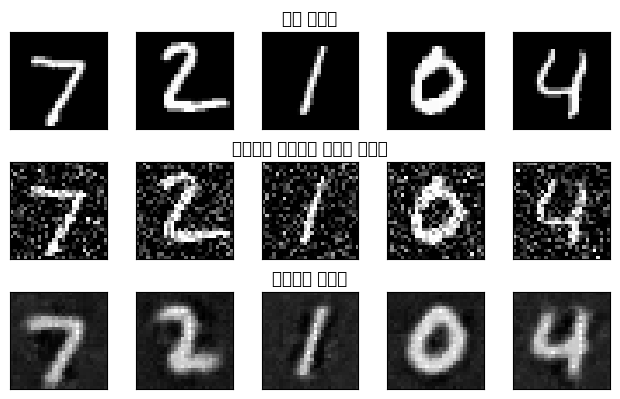

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.054 	 val loss 0.044


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


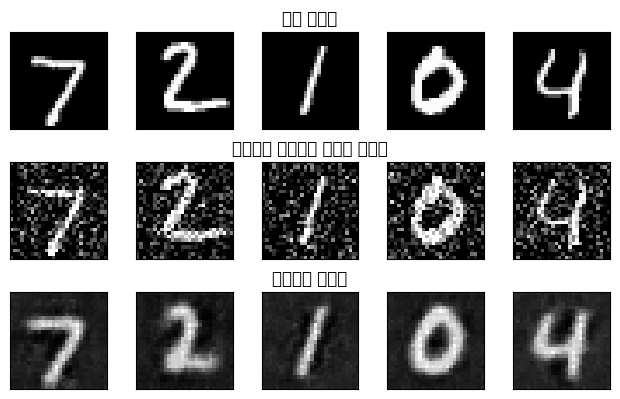

EPOCH 6/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 6/30 	 train loss 0.053 	 val loss 0.043


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


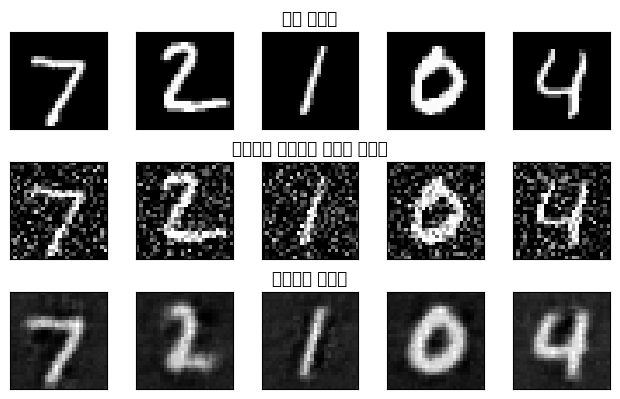

EPOCH 7/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 7/30 	 train loss 0.053 	 val loss 0.042


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


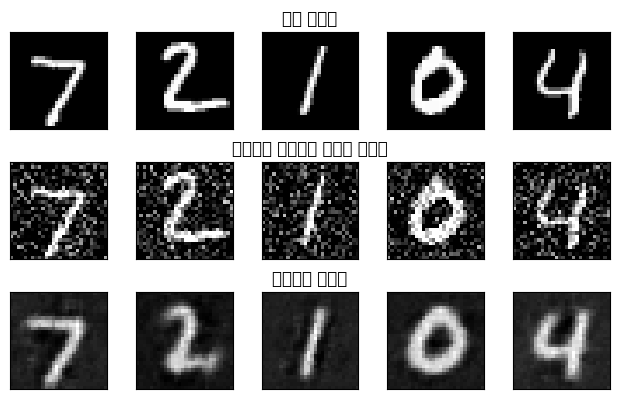

EPOCH 8/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 8/30 	 train loss 0.052 	 val loss 0.041


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


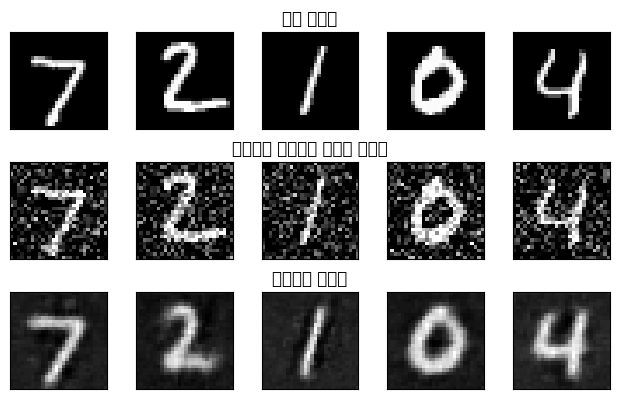

EPOCH 9/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 9/30 	 train loss 0.052 	 val loss 0.040


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


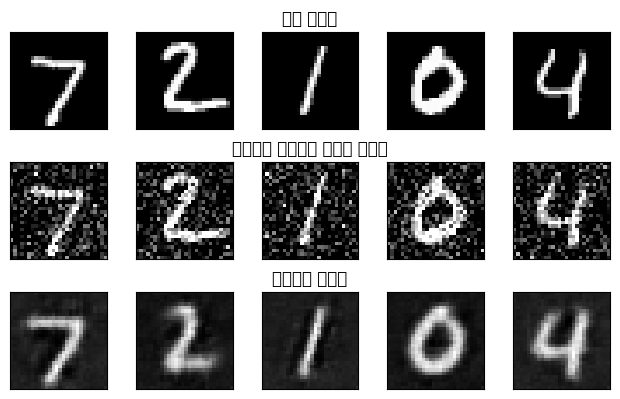

EPOCH 10/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 10/30 	 train loss 0.051 	 val loss 0.040


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


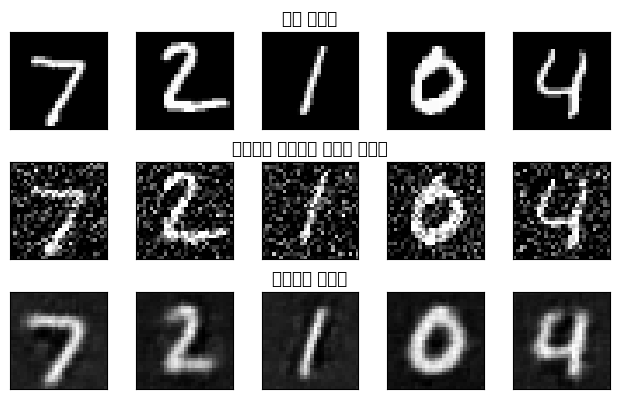

EPOCH 11/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 11/30 	 train loss 0.051 	 val loss 0.040


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


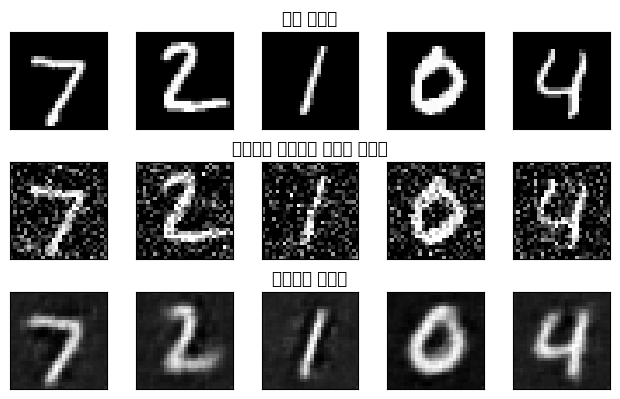

EPOCH 12/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 12/30 	 train loss 0.051 	 val loss 0.040


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


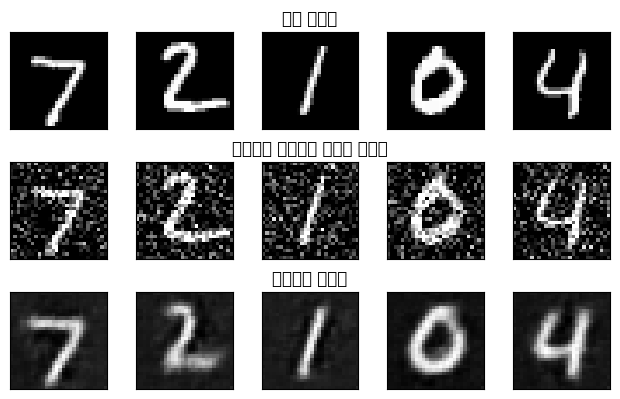

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.051 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


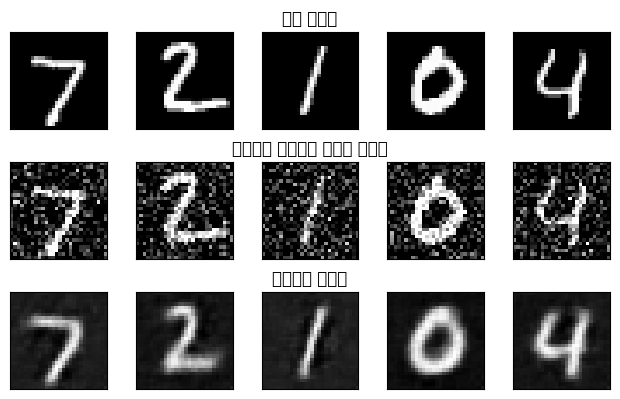

EPOCH 14/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 14/30 	 train loss 0.051 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


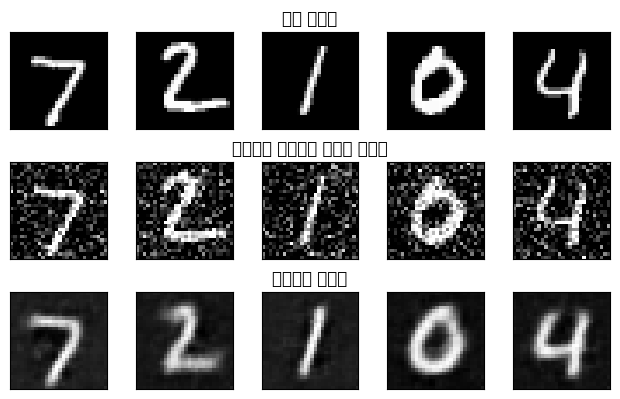

EPOCH 15/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


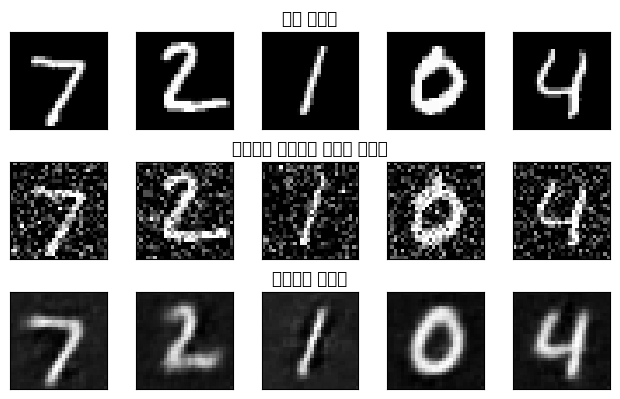

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


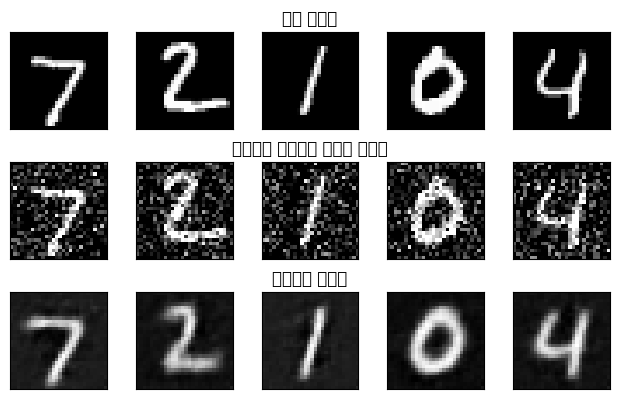

EPOCH 17/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


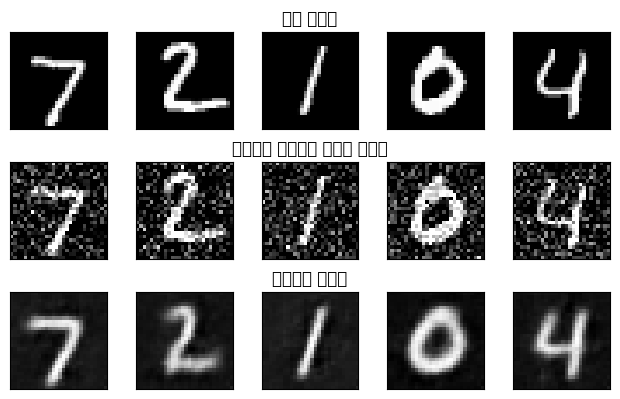

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


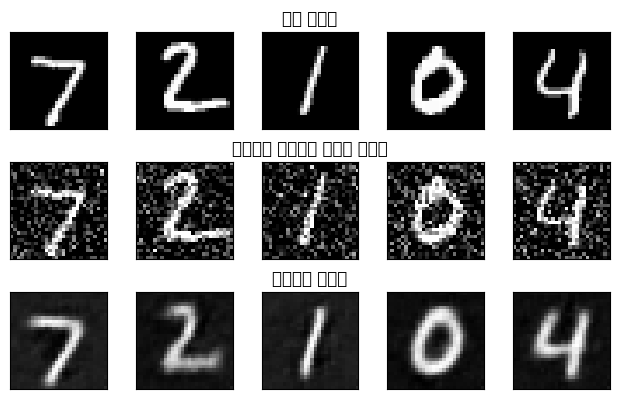

EPOCH 19/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


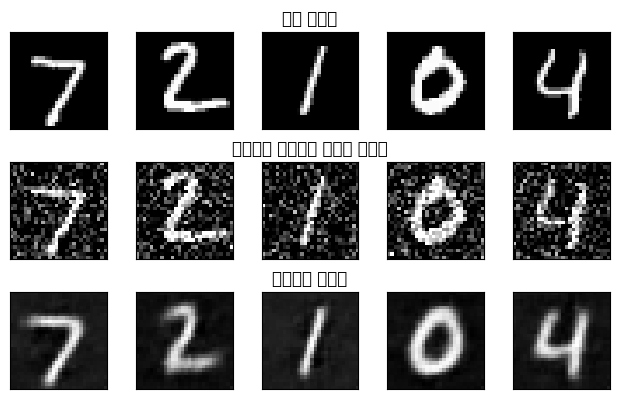

EPOCH 20/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 20/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


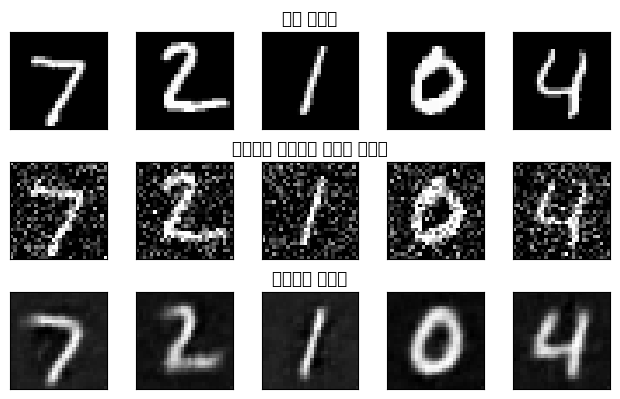

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


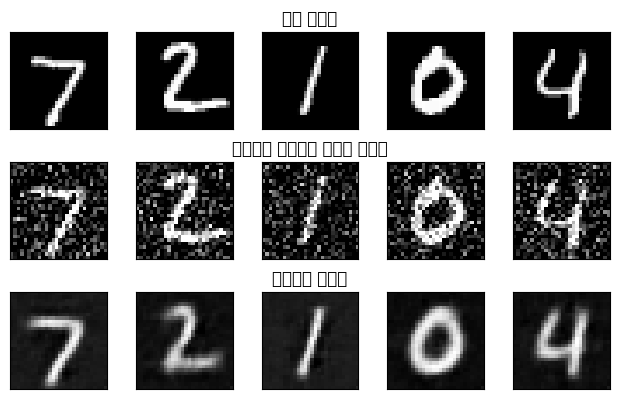

EPOCH 22/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


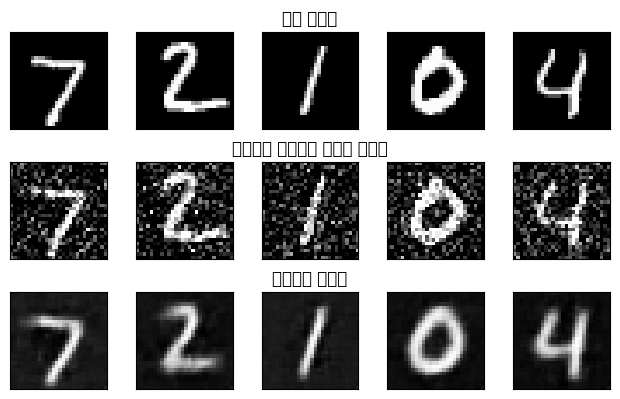

EPOCH 23/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 23/30 	 train loss 0.050 	 val loss 0.039


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


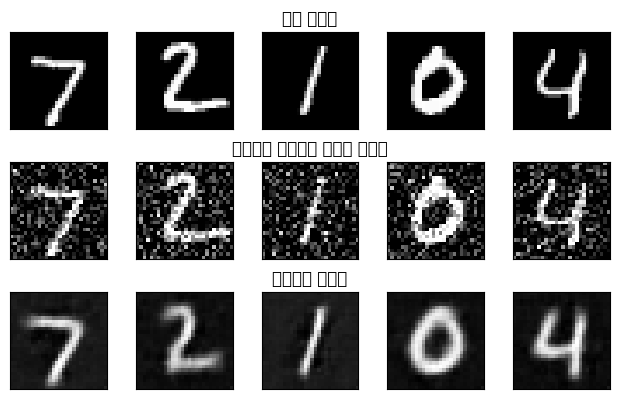

EPOCH 24/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 24/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


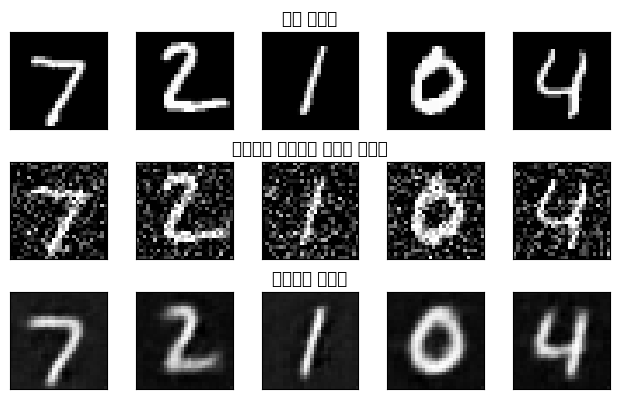

EPOCH 25/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 25/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


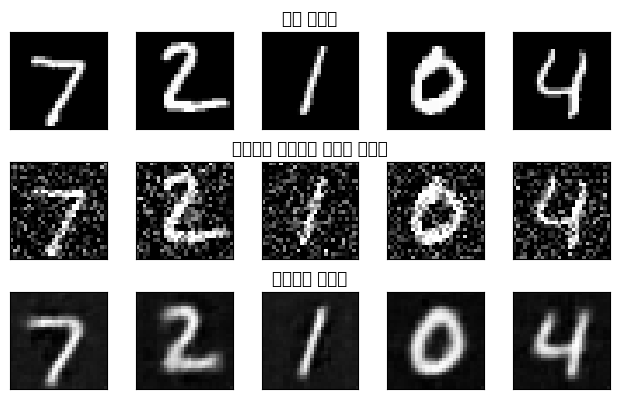

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


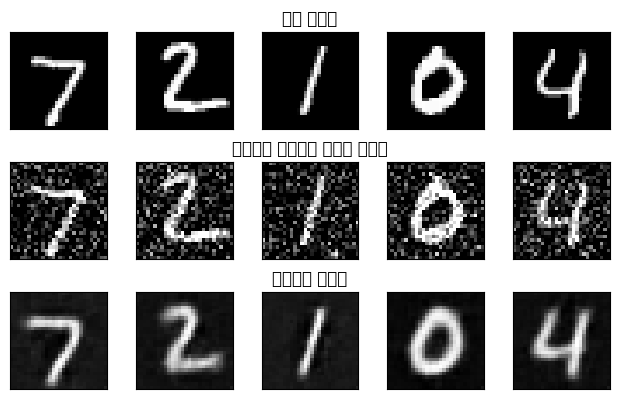

EPOCH 27/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 27/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


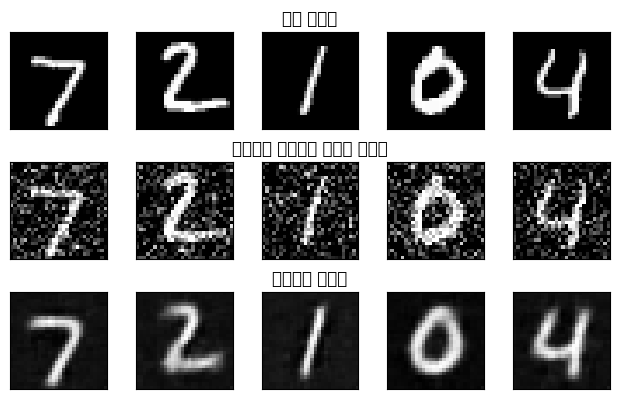

EPOCH 28/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 28/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


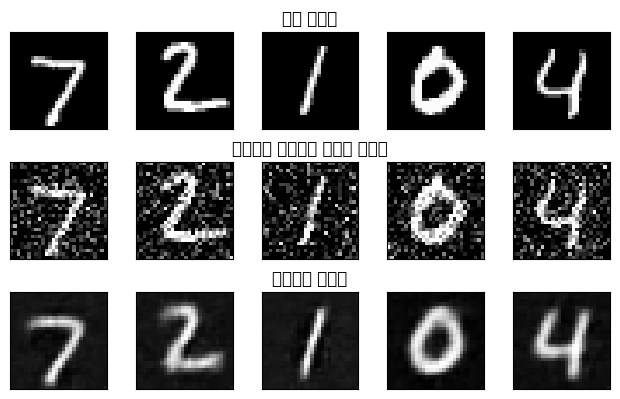

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


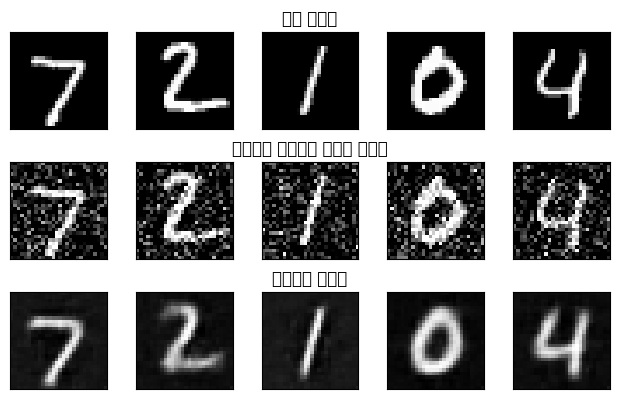

EPOCH 30/30


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.



 EPOCH 30/30 	 train loss 0.050 	 val loss 0.038


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


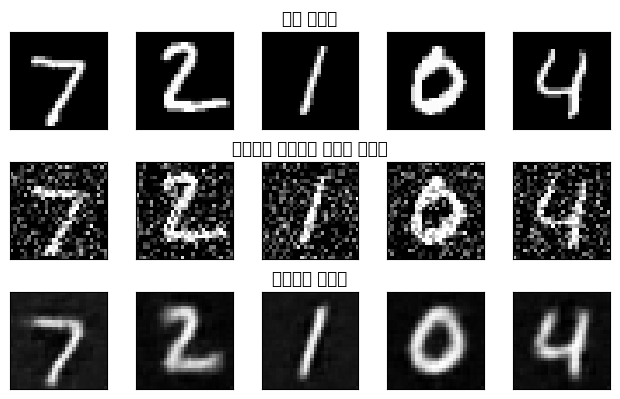

In [10]:
# 코드 13-10 모델 학습
import numpy as np

num_epochs = 30
history_da = {"train_loss": [], "val_loss": []}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print("EPOCH %d/%d" % (epoch + 1, num_epochs))
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim,
        noise_factor=0.3,
    )  # 모델 학습 함수(train_epoch)를 이용하여 모델 학습
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn,
        noise_factor=0.3,
    )  # 모델 검증(테스트) 함수(test_epoch)를 이용하여 테스트
    history_da["train_loss"].append(train_loss)
    history_da["val_loss"].append(val_loss)
    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)